<a href="https://colab.research.google.com/github/pavansai26/anusha-task1/blob/master/sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from scipy.stats import boxcox
from os import listdir

In [ ]:
pip install shap

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import shap
shap.initjs()


In [ ]:
pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 1000)

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
data=pd.read_csv('/gdrive/My Drive/Colab Notebooks/Data_csv.csv',encoding = 'ISO-8859-1')

In [ ]:
missing_percentage = data.isnull().sum() / data.shape[0] * 100
missing_percentage

In [ ]:
data[data['product description'].isnull()].head()

In [ ]:
data["InvoiceDate"] = pd.to_datetime(data['transaction timestamp'], cache=True)

data.InvoiceDate.max() - data.InvoiceDate.min()

In [ ]:
print("Datafile starts with timepoint {}".format(data.InvoiceDate.min()))
print("Datafile ends with timepoint {}".format(data.InvoiceDate.max()))

In [ ]:
data["IsCancelled"]=np.where(data['ï»¿transaction id'].apply(lambda l: l[0]=="C"), True, False)
data.IsCancelled.value_counts() / data.shape[0] * 100

In [ ]:
data.loc[data.IsCancelled==True].describe()

In [ ]:
data = data.loc[data.IsCancelled==False].copy()
data = data.drop("IsCancelled", axis=1)

In [ ]:
data['product id'].nunique()

In [ ]:
stockcode_counts = data['product id'].value_counts().sort_values(ascending=False)
fig, ax = plt.subplots(2,1,figsize=(20,15))
sns.barplot(stockcode_counts.iloc[0:20].index,
            stockcode_counts.iloc[0:20].values,
            ax = ax[0], palette="Oranges_r")
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Stockcode")
ax[0].set_title("Which stockcodes are most common?");
sns.distplot(np.round(stockcode_counts/data.shape[0]*100,2),
             kde=False,
             bins=20,
             ax=ax[1], color="Orange")
ax[1].set_title("How seldom are stockcodes?")
ax[1].set_xlabel("% of data with this stockcode")
ax[1].set_ylabel("Frequency");


In [ ]:
description_counts = data['product description'].value_counts().sort_values(ascending=False).iloc[0:30]
plt.figure(figsize=(20,5))
sns.barplot(description_counts.index, description_counts.values, palette="Purples_r")
plt.ylabel("Counts")
plt.title("Which product descriptions are most common?");
plt.xticks(rotation=90);

In [ ]:
customer_counts = data['customer id'].value_counts().sort_values(ascending=False).iloc[0:20] 
plt.figure(figsize=(20,5))
sns.barplot(customer_counts.index, customer_counts.values, order=customer_counts.index)
plt.ylabel("Counts")
plt.xlabel("CustomerID")
plt.title("Which customers are most common?");
plt.xticks(rotation=90);

In [ ]:
country_counts = data['transaction country'].value_counts().sort_values(ascending=False).iloc[0:20]
plt.figure(figsize=(20,5))
sns.barplot(country_counts.index, country_counts.values, palette="Greens_r")
plt.ylabel("Counts")
plt.title("Which countries made the most transactions?");
plt.xticks(rotation=90);
plt.yscale("log")

How many percentage of entries are inside UK?

In [ ]:
data.loc[data['transaction country']=="United Kingdom"].shape[0] / data.shape[0] * 100

 indicate inside or outside of the UK:

In [ ]:
data["UK"] = np.where(data['transaction country'] == "United Kingdom", 1, 0)

In [ ]:
data.loc[data['unit price'] == 0].sort_values(by="quantity sold", ascending=False).head()

In [ ]:
data["Revenue"] = data['quantity sold'] * data['unit price']



In [ ]:
data=data.iloc[:,:9]

In [ ]:
data

In [ ]:
data['time'] = pd.to_datetime(data['transaction timestamp'])

In [ ]:
data

In [ ]:
data["Revenue"] = data['quantity sold'] * data['unit price']

data["Year"] = data['time'].dt.year
data["Quarter"] = data['time'].dt.quarter
data["Month"] = data['time'].dt.month
data["Week"] = data['time'].dt.week
data["Weekday"] = data['time'].dt.weekday
data["Day"] = data['time'].dt.day
data["Dayofyear"] = data['time'].dt.dayofyear
data["Date"] = pd.to_datetime(data[['Year', 'Month', 'Day']])

In [ ]:
data['quantity'] = data['quantity sold']
print(data['quantity'])

In [ ]:
grouped_features = ["Date", "Year", "Quarter","Month", "Week", "Weekday", "Dayofyear", "Day",
                    "product id"]

In [ ]:
daily_data = pd.DataFrame(data.groupby(grouped_features).quantity.sum(),
                          columns=["quantity"])
daily_data["Revenue"] = data.groupby(grouped_features).Revenue.sum()
daily_data = daily_data.reset_index()
daily_data

In [ ]:
samples = daily_data.shape[0]

In [ ]:
low_quantity = daily_data.quantity.quantile(0.01)
high_quantity = daily_data.quantity.quantile(0.99)
print((low_quantity, high_quantity))

In [ ]:
low_revenue = daily_data.Revenue.quantile(0.01)
high_revenue = daily_data.Revenue.quantile(0.99)
print((low_revenue, high_revenue))

In [ ]:
daily_data = daily_data.loc[
    (daily_data.quantity >= low_quantity) & (daily_data.quantity <= high_quantity)]
daily_data = daily_data.loc[
    (daily_data.Revenue >= low_revenue) & (daily_data.Revenue <= high_revenue)]

How much entries have we lost?

In [ ]:
samples - daily_data.shape[0]

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(daily_data.quantity.values, kde=True, ax=ax[0], color="Orange", bins=30);
sns.distplot(np.log(daily_data.quantity.values), kde=True, ax=ax[1], color="Orange", bins=30);
ax[0].set_xlabel("Number of daily product sales");
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many products are sold per day?");

In [78]:
daily_data.head()

,product id,Year,Month,Week,Weekday,Date,Quarter,Dayofyear,Day,quantity,Revenue,ProductType,KnownStockCodeUnitPriceMedian,KnownStockCodeUnitPriceIQR,KnownStockCodePrice_WW_median,KnownStockCodePrice_WW_mean,KnownStockCodePrice_WW_std
0,10002,2010,12,48,2,2010-12-01,4,335,1,4.094345,51.00,1,0.85,0.78,0.85,0.85,0.0
1,10125,2010,12,48,2,2010-12-01,4,335,1,0.693147,1.70,22,0.85,0.04,0.85,0.85,NaN
2,10133,2010,12,48,2,2010-12-01,4,335,1,1.609438,4.25,16,0.79,0.41,0.85,0.85,NaN
3,10135,2010,12,48,2,2010-12-01,4,335,1,0.000000,2.51,9,1.25,0.03,2.51,2.51,NaN
4,11001,2010,12,48,2,2010-12-01,4,335,1,1.098612,10.08,22,1.69,0.00,3.36,3.36,NaN


In [57]:
week = daily_data.Week.max() - 2
print("Validation after week {}".format(week))
print("Validation starts at timepoint {}".format(
    daily_data[daily_data.Week==week].Date.min()
))

Validation after week 49
Validation starts at timepoint 2010-12-06 00:00:00


In [65]:
products = pd.DataFrame(index=data.loc[data.Week < week]['product id'].unique(), columns = ["MedianPrice"])

products["MedianPrice"] = data.loc[data.Week < week].groupby("product id")['unit price'].median()
products["MedianQuantities"] = data.loc[data.Week < week].groupby("product id").quantity.median()
products["Customers"] = data.loc[data.Week < week].groupby("product id")['customer id'].nunique()
org_cols = np.copy(products.columns.values)
products.head()

,MedianPrice,MedianQuantities,Customers
85123A,2.95,6.0,825
71053,3.75,4.0,138
84406B,4.15,4.0,126
84029G,4.25,3.0,171
84029E,4.25,4.0,176


In [66]:
X = products.values
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [68]:
km = KMeans(n_clusters=30)
products["cluster"] = km.fit_predict(X)

daily_data["ProductType"] = daily_data['product id'].map(products.cluster)
daily_data.ProductType = daily_data.ProductType.astype("object")
daily_data.head()

,Date,Year,Quarter,Month,Week,Weekday,Dayofyear,Day,product id,quantity,Revenue,ProductType
0,2010-12-01,2010,4,12,48,2,335,1,10002,4.094345,51.00,1
1,2010-12-01,2010,4,12,48,2,335,1,10125,0.693147,1.70,22
2,2010-12-01,2010,4,12,48,2,335,1,10133,1.609438,4.25,16
3,2010-12-01,2010,4,12,48,2,335,1,10135,0.000000,2.51,9
4,2010-12-01,2010,4,12,48,2,335,1,11001,1.098612,10.08,22


In [71]:
daily_data["KnownStockCodeUnitPriceMedian"] = daily_data['product id'].map(
    data.groupby("product id")['unit price'].median())

known_price_iqr = data.groupby("product id")['unit price'].quantile(0.75) 
known_price_iqr -= data.groupby("product id")['unit price'].quantile(0.25) 
daily_data["KnownStockCodeUnitPriceIQR"] = daily_data['product id'].map(known_price_iqr)

In [73]:
to_group = ["product id", "Year", "Month", "Week", "Weekday"]

daily_data = daily_data.set_index(to_group)
daily_data["KnownStockCodePrice_WW_median"] = daily_data.index.map(
    data.groupby(to_group)['unit price'].median())
daily_data["KnownStockCodePrice_WW_mean"] = daily_data.index.map(
    data.groupby(to_group)['unit price'].mean().apply(lambda l: np.round(l, 2)))
daily_data["KnownStockCodePrice_WW_std"] = daily_data.index.map(
    data.groupby(to_group)['unit price'].std().apply(lambda l: np.round(l, 2)))

daily_data = daily_data.reset_index()

In [74]:
daily_data.head()

,product id,Year,Month,Week,Weekday,Date,Quarter,Dayofyear,Day,quantity,Revenue,ProductType,KnownStockCodeUnitPriceMedian,KnownStockCodeUnitPriceIQR,KnownStockCodePrice_WW_median,KnownStockCodePrice_WW_mean,KnownStockCodePrice_WW_std
0,10002,2010,12,48,2,2010-12-01,4,335,1,4.094345,51.00,1,0.85,0.78,0.85,0.85,0.0
1,10125,2010,12,48,2,2010-12-01,4,335,1,0.693147,1.70,22,0.85,0.04,0.85,0.85,NaN
2,10133,2010,12,48,2,2010-12-01,4,335,1,1.609438,4.25,16,0.79,0.41,0.85,0.85,NaN
3,10135,2010,12,48,2,2010-12-01,4,335,1,0.000000,2.51,9,1.25,0.03,2.51,2.51,NaN
4,11001,2010,12,48,2,2010-12-01,4,335,1,1.098612,10.08,22,1.69,0.00,3.36,3.36,NaN


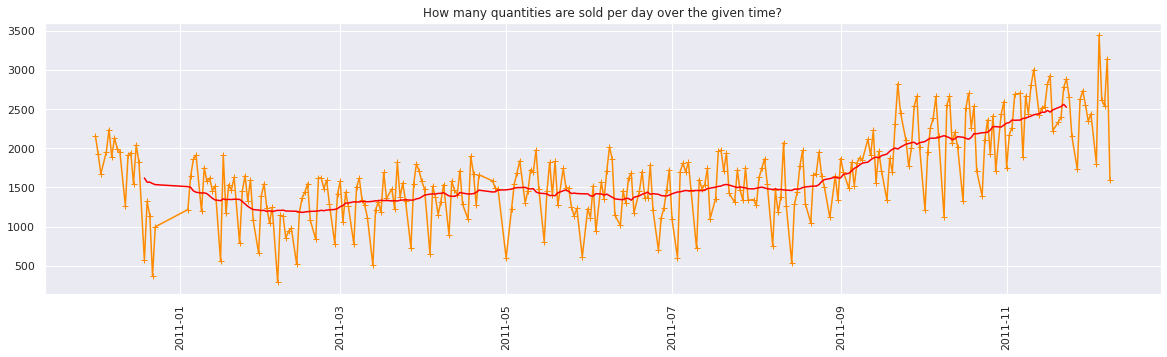

In [76]:
plt.figure(figsize=(20,5))
plt.plot(daily_data.groupby("Date").quantity.sum(), marker='+', c="darkorange")
plt.plot(daily_data.groupby("Date").quantity.sum().rolling(window=30, center=True).mean(),
        c="red")
plt.xticks(rotation=90);
plt.title("How many quantities are sold per day over the given time?");

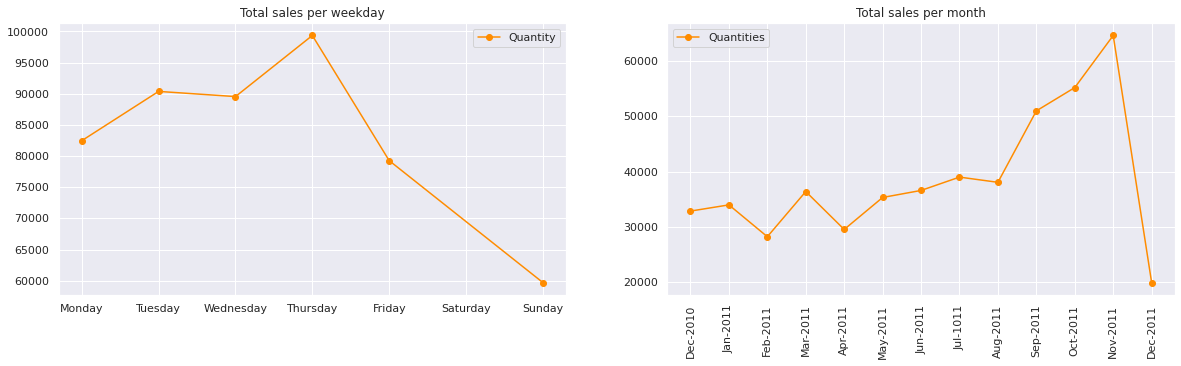

In [77]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
yearmonth = ["Dec-2010", "Jan-2011", "Feb-2011", "Mar-2011", "Apr-2011", "May-2011",
             "Jun-2011", "Jul-1011", "Aug-2011", "Sep-2011", "Oct-2011", "Nov-2011", 
             "Dec-2011"]

daily_data.groupby("Weekday").quantity.sum().plot(
    ax=ax[0], marker='o', label="Quantity", c="darkorange");
ax[0].legend();
ax[0].set_xticks(np.arange(0,7))
ax[0].set_xticklabels(weekdays);
ax[0].set_xlabel("")
ax[0].set_title("Total sales per weekday");

ax[1].plot(daily_data.groupby(["Year", "Month"]).quantity.sum().values,
    marker='o', label="Quantities", c="darkorange");
ax[1].set_xticklabels(yearmonth, rotation=90)
ax[1].set_xticks(np.arange(0, len(yearmonth)))
ax[1].legend();
ax[1].set_title("Total sales per month");